# Задача: Выявление аномальных (накрученных) кликов в рекламной кампании.

## Цель
Выявить аномальные клики в рекламной кампании.


## Содержание
* [Резюме](#резюме)
* [Импорт библиотек и настройки](#импорт-библиотек-и-настройки)
* [Исследуемые данные](#исследуемые-данные)
* [Анализ](#анализ)
    * [1. Загрузка и первичный анализ данных](#1-загрузка-и-первичный-анализ-данных)
    * [2. Ручной анализ кликов](#2-ручной-анализ-кликов)
    * [3. Кластеризация K-средних](#3-кластеризация-к-средних-k-means-clustering)
    * [4. Кластеризация DBSCAN](#4-кластеризация-dbscan)
* [Итоги](#итоги)


## Резюме
В ходе исследования были использованы три различных подхода к решению задачи нахождения аномальных (накрученных) кликов:
1. Ручная проверка - сравнение количества кликов и показов, параметров кликов и показов в рамках одного eid, а также временных интервалов между кликами и показами. Были выделены случаи кликов без предшествующих показов, клики и показы с различными характеристиками сети, клики со слишком коротким временным интервалом после показа (менее 5 секунд). Этот метод оказался наиболее полезным для идентификации аномалий, а также задал начальные критерии для дальнейшего анализа.
2. Кластеризация К-средних (K-means clustering) - был использован алгоритм KMeans для поиска аномальных точек: как в виде отдельного кластера, так и на основе расстояния до центроида. В рамках данного подхода был определен порог аномальности, используя 95-й процентиль для расстояния до ближайшего центроида. Клики, сильно отклоняющиеся от своих центроидов, были помечены как аномальные. Однако этот метод не дал однозначно интерпретируемых результатов.
3. Кластеризация DBSCAN - для выявления аномалий был применен метод кластеризации DBSCAN. Этот алгоритм позволяет находить кластеры произвольной формы и выделять выбросы, используя минимальное количество точек в кластере и радиус окружности (эпсилон). DBSCAN оказался достаточно полезным для выделения аномальных точек. В результате применения данного алгоритма около половины аномальных точек, согласно ручному анализу, были классифицированы как выбросы.

Таким образом, использование данных трех подходов дало возможность более полно провести анализ тестовых данных на наличие аномальных кликов. Однако наиболее корректным методом остается ручной анализ, так как результаты кластеризации, представленные здесь, служат лишь дополнительным инструментом для демонстрации имеющихся возможностей и навыков. На текущий момент кластеризация в приведенном ниже виде не подходит для получения реальных результатов.

В результате проведенного анализа было выявлено, что тестовые данные содержат 543 накрученных клика (35 % от общего числа кликов). Файл 'anomalous_clicks.tsv' с аномальными кликами находится в папке 'data'.

## Импорт библиотек и настройки


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, KMeans
from yellowbrick.cluster import silhouette_visualizer

## Исследуемые данные
В данном исследовании используется таблица кликов и показов рекламных баннеров ('test_data.tsv').

Основные признаки включают:

eid - id группы событий (показа и клика к нему);

t - время;

user - id пользователя;

tn - тип события; 

geo -  id региона;

cnethash - хеш от сети класса С, к которой принадлежит ip пользователя;

devtype - тип устройства;

brotype - тип браузера;

bsize - id размера банера;

siteid - id канала поставщика трафика;

domhash - хеш от домена;

urlhash - хеш от урла.

## Анализ
### 1. Загрузка и первичный анализ данных


In [2]:
df = pd.read_csv('data/test_data.tsv', sep='\t')

In [3]:
df.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48672 entries, 0 to 48671
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   eid       48672 non-null  int64 
 1   t         48672 non-null  int64 
 2   user      48672 non-null  int64 
 3   tn        48672 non-null  int64 
 4   geo       48672 non-null  int64 
 5   cnethash  48672 non-null  uint64
 6   devtype   48672 non-null  int64 
 7   brotype   48672 non-null  int64 
 8   bsize     48672 non-null  int64 
 9   siteid    48672 non-null  int64 
 10  domhash   48672 non-null  uint64
 11  urlhash   48672 non-null  uint64
dtypes: int64(9), uint64(3)
memory usage: 4.5 MB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
eid,48672.0,1.839659e+11,1.515438e+11,0.000000e+00,2.616135e+10,2.981588e+11,3.274143e+11,3.585147e+11
t,48672.0,6.159339e+05,3.711636e+05,0.000000e+00,2.925945e+05,6.149685e+05,9.430910e+05,1.248945e+06
user,48672.0,4.727870e+04,2.969635e+04,2.100000e+01,1.977700e+04,4.268500e+04,7.392625e+04,9.999500e+04
tn,48672.0,3.178419e-02,1.754269e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
geo,48672.0,1.984569e+09,1.422521e+09,1.161199e+08,2.394769e+08,2.169085e+09,3.369870e+09,4.249820e+09
cnethash,48672.0,9.038490e+18,5.203751e+18,8.017871e+15,4.778815e+18,8.778147e+18,1.362199e+19,1.843329e+19
devtype,48672.0,2.437521e+00,5.131862e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
brotype,48672.0,2.365364e+00,1.557641e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.100000e+01
bsize,48672.0,2.984298e+09,1.257619e+09,3.903048e+08,2.286541e+09,3.529440e+09,3.529440e+09,4.243176e+09
siteid,48672.0,1.766026e+09,5.747049e+08,2.516384e+08,1.732823e+09,1.732823e+09,2.019280e+09,3.629549e+09


In [6]:
df.isnull().sum()

eid         0
t           0
user        0
tn          0
geo         0
cnethash    0
devtype     0
brotype     0
bsize       0
siteid      0
domhash     0
urlhash     0
dtype: int64

In [7]:
df['tn'].value_counts()

tn
0    47125
1     1547
Name: count, dtype: int64

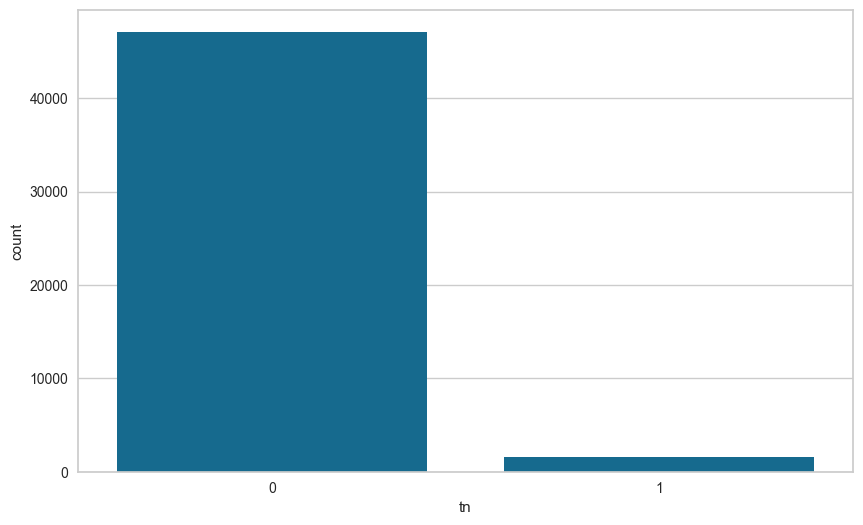

In [8]:
plt.figure(figsize=(10,6), dpi=100)
sns.countplot(df, x='tn');

In [9]:
df['eid'].nunique()

47157

In [10]:
group_sizes = df.groupby('eid').size()
max_rows_per_eid = group_sizes.max()
min_rows_per_eid = group_sizes.min()

max_rows_per_eid, min_rows_per_eid

(2, 1)

Видно, что приведенный датасет data_test.tsv состоит из 48672 строк и 12 колонок. В данных нет пропущенных значений. В основном все признаки являются категориальными, кроме времени. Данные можно разделить на 47125 показов и 1547 кликов. Для каждого отдельного eid присутствует либо пара 'показ-клик', либо только одно из этих двух событий. 

Далее перейдем к анализу кликов.

### 2. Ручной анализ кликов

Задачу ручного поиска аномальных (накрученных) кликов можно разделить на 3 шага:

1. Поиск кликов без показов в рамках одного 'eid'. Такое поведение сразу можно считать подозрительным и приравнять клики к аномальным.

2. Поиск кликов, у которых есть показы в рамках одного 'eid', но какие-либо из параметров у кликов и показов не совпадают.

3. Поиск кликов, где временной промежуток между кликом и соответствующим показом слишком мал. Например, возьмем пороговое значение, равное 5 секундам.

Разделим данные на показы и клики.

In [11]:
shows = df[df['tn'] == 0]
clicks = df[df['tn'] == 1]

Найдем клики без показов в рамках одного 'eid'.

In [12]:
clicks_without_shows = clicks[~clicks['eid'].isin(shows['eid'])]
len(clicks_without_shows)

32

Добавим в датасет clicks дополнительный столбец 'manual_anomalous', принимающий значение 1 для аномальных(накрученных) кликов и значение 0 - для обычных.

In [13]:
clicks['manual_anomalous'] = ~clicks['eid'].isin(shows['eid'])
clicks['manual_anomalous'] = clicks['manual_anomalous'].astype(int)

/var/folders/jj/m72b8bbx36nctf7xmyqr08hc0000gn/T/ipykernel_4241/2481509696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks['manual_anomalous'] = ~clicks['eid'].isin(shows['eid'])
/var/folders/jj/m72b8bbx36nctf7xmyqr08hc0000gn/T/ipykernel_4241/2481509696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks['manual_anomalous'] = clicks['manual_anomalous'].astype(int)


In [14]:
clicks[clicks['manual_anomalous'] == 1]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous
2348,37441457860,875284,4016,1,3202151794,12167583043113862321,3,2,1642713892,673473971,9637082841571769563,9006131544472307012,1
6497,12255754977,287778,11780,1,3325052880,4393195193369624022,2,2,2286540757,673473971,18128488130148077095,1700358976836604444,1
8629,31180077115,729632,16085,1,948975964,7153086747091725409,3,2,2286540757,673473971,4673054231720875644,5341162864055083811,1
8962,35029231286,813692,16618,1,3371039404,6406880047108242353,2,2,2286540757,673473971,13692820271423469583,8217818528289523872,1
10044,300877845998,97093,17206,1,2169085419,12557905364404771101,3,2,1642713892,673473971,11102315483450219777,1042283592460130546,1
12652,34223041087,800848,21667,1,1375834299,5750135913595494708,2,2,3529439892,673473971,396458172229163680,1422457161789697594,1
14203,331938830984,730956,24361,1,2960729952,2048524833328793252,3,9,390304810,673473971,17746806286717186239,2598975503797220285,1
15299,315698274417,402694,26367,1,3805942148,13136189517371146609,2,2,2286540757,673473971,15630579387847758071,321350793863227973,1
16168,331455469289,723902,29164,1,390304810,4972980481382939957,2,2,390304810,673473971,8425617363021880388,5218715724162770495,1
23911,335446633703,802641,40343,1,239476928,7153086747091725409,3,2,4243176437,673473971,15262017513205079826,12176601370563817825,1


Таким образом, после первого шага были выявлены 32 подозрительных клика.

Далее найдем клики, которым предшествовали показы, но параметры (пользователя, сети) у кликов и показов не совпадали. Объединим датасеты кликов и показов и проверим каждый из параметров на соответствие друг другу.

In [15]:
merged_data = pd.merge(clicks, shows, on='eid', suffixes=('_c', '_sh'))
                                               
anomalous_data = merged_data[
    (merged_data['user_c'] != merged_data['user_sh']) |
    (merged_data['geo_c'] != merged_data['geo_sh']) |
    (merged_data['cnethash_c'] != merged_data['cnethash_sh']) |
    (merged_data['devtype_c'] != merged_data['devtype_sh']) |
    (merged_data['brotype_c'] != merged_data['brotype_sh']) |
    (merged_data['bsize_c'] != merged_data['bsize_sh']) |
    (merged_data['siteid_c'] != merged_data['siteid_sh']) |
    (merged_data['domhash_c'] != merged_data['domhash_sh']) |
    (merged_data['urlhash_c'] != merged_data['urlhash_sh'])
]
anomalous_data

,eid,t_c,user_c,tn_c,geo_c,cnethash_c,devtype_c,brotype_c,bsize_c,siteid_c,...,user_sh,tn_sh,geo_sh,cnethash_sh,devtype_sh,brotype_sh,bsize_sh,siteid_sh,domhash_sh,urlhash_sh
5,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,...,1242,0,239476928,9857242284640379126,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572
11,52000519449,1205756,1561,1,3369870328,7153086747091725409,3,2,4059410016,1732823002,...,1561,0,3369870328,4212828685740511721,3,2,4059410016,1732823002,6855870238177867981,16629187871008095825
12,52002565624,1205800,1561,1,3369870328,7153086747091725409,3,2,390304810,1732823002,...,1561,0,3369870328,4212828685740511721,3,2,390304810,1732823002,6855870238177867981,11452130590352027305
90,19975967490,474138,5253,1,948975964,7153086747091725409,3,2,390304810,2019279739,...,5253,0,948975964,14007409272261363015,3,2,390304810,2019279739,7393640079027845389,7365785318488129214
91,53918883901,1237856,5253,1,948975964,12557905364404771101,3,2,2286540757,2019279739,...,5253,0,948975964,2006819638603974698,3,2,2286540757,2019279739,15112805901111966778,2645025979328414583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,305311971443,188554,91887,1,3031418426,12557905364404771101,3,2,3529439892,1732823002,...,91887,0,3031418426,13182337754668979646,3,2,3529439892,1732823002,13824403851235818059,6566218145263445341
1415,305311974313,188554,91887,1,3031418426,3945510463781236591,3,2,3529439892,1732823002,...,91887,0,3031418426,13182337754668979646,3,2,3529439892,1732823002,13824403851235818059,6566218145263445341
1500,2144465014,45781,98530,1,2169085419,14973186603124042070,2,2,4059410016,251638358,...,98530,0,2169085419,14092039600870638695,2,2,4059410016,251638358,7421428344451901936,13727194336146148354
1509,4075834339,101107,99144,1,2169085419,4239896307392508400,3,2,1642713892,673473971,...,99144,0,2169085419,7489913687936380911,3,2,1642713892,673473971,5994715955150846703,5948040011910253044


Добавим в датасет clicks значение 1 для столбца 'manual_anomalous' для этих аномальных кликов.

In [16]:
anomalous_eids = anomalous_data['eid'].unique()
clicks.loc[clicks['eid'].isin(anomalous_eids), 'manual_anomalous'] = 1

In [17]:
clicks[clicks['manual_anomalous'] == 1]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous
249,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,1
357,52000519449,1205756,1561,1,3369870328,7153086747091725409,3,2,4059410016,1732823002,6855870238177867981,16629187871008095825,1
359,52002565624,1205800,1561,1,3369870328,7153086747091725409,3,2,390304810,1732823002,6855870238177867981,11452130590352027305,1
2348,37441457860,875284,4016,1,3202151794,12167583043113862321,3,2,1642713892,673473971,9637082841571769563,9006131544472307012,1
3113,19975967490,474138,5253,1,948975964,7153086747091725409,3,2,390304810,2019279739,7393640079027845389,7365785318488129214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48352,2144465014,45781,98530,1,2169085419,14973186603124042070,2,2,4059410016,251638358,7421428344451901936,13727194336146148354,1
48442,4075834339,101107,99144,1,2169085419,4239896307392508400,3,2,1642713892,673473971,5994715955150846703,5948040011910253044,1
48449,32980152028,779879,99144,1,2169085419,3627804543293043122,3,2,4243176437,673473971,6857424429110098085,16105238177886081616,1
48465,42055971128,973084,99209,1,239476928,9808897751740002020,2,2,2286540757,673473971,18369807234757086389,16595477858679529831,1


После первых двух шагов 118 кликов были классифицированы как аномальные.

Далее найдем клики и показы, временной промежуток между которыми составляет менее 5 секунд. В том числе,сюда попадут и те клики, которые были совершены раньше соответствующих показов (то есть разница во времени будет отрицательной).

In [18]:
merged_data['time_diff'] = merged_data['t_c'] - merged_data['t_sh']
short_time_diff = merged_data[merged_data['time_diff'] < 5]
short_time_diff

,eid,t_c,user_c,tn_c,geo_c,cnethash_c,devtype_c,brotype_c,bsize_c,siteid_c,...,tn_sh,geo_sh,cnethash_sh,devtype_sh,brotype_sh,bsize_sh,siteid_sh,domhash_sh,urlhash_sh,time_diff
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,...,0,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,4
5,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,...,0,239476928,9857242284640379126,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,2
6,356485962288,1219612,1435,1,390304810,1192490853539771097,3,2,3529439892,2019279739,...,0,390304810,1192490853539771097,3,2,3529439892,2019279739,8416208933617365004,9497642917282163363,4
7,13938138174,336280,1492,1,239476928,17272734299351518174,2,2,3529439892,1732823002,...,0,239476928,17272734299351518174,2,2,3529439892,1732823002,16593058030122958800,10314716605508635827,3
25,325178650673,610434,1636,1,239476928,3395782206471752809,2,2,3529439892,1732823002,...,0,239476928,3395782206471752809,2,2,3529439892,1732823002,16593058030122958800,10314716605508635827,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,331655696273,726618,98471,1,239476928,14767479604087834668,3,2,3529439892,1732823002,...,0,239476928,14767479604087834668,3,2,3529439892,1732823002,8016818914374733663,1431829537275018691,4
1498,349213197554,1072127,98471,1,239476928,14767479604087834668,3,2,3529439892,1732823002,...,0,239476928,14767479604087834668,3,2,3529439892,1732823002,16593058030122958800,10314716605508635827,4
1499,354463058672,1177126,98471,1,239476928,14767479604087834668,3,2,3529439892,1732823002,...,0,239476928,14767479604087834668,3,2,3529439892,1732823002,16593058030122958800,10314716605508635827,4
1501,29420927608,700850,98563,1,3371039404,3363403701833730854,2,2,4059410016,1732823002,...,0,3371039404,3363403701833730854,2,2,4059410016,1732823002,8226252734070597606,17200119249000175952,3


Добавим в датасет clicks значение 1 для столбца 'manual_anomalous' для этих аномальных кликов.

In [19]:
anomalous_eids = short_time_diff['eid'].unique()
clicks.loc[clicks['eid'].isin(anomalous_eids), 'manual_anomalous'] = 1

In [20]:
clicks[clicks['manual_anomalous'] == 1]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous
42,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1
249,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,1
306,356485962288,1219612,1435,1,390304810,1192490853539771097,3,2,3529439892,2019279739,8416208933617365004,9497642917282163363,1
315,13938138174,336280,1492,1,239476928,17272734299351518174,2,2,3529439892,1732823002,16593058030122958800,10314716605508635827,1
357,52000519449,1205756,1561,1,3369870328,7153086747091725409,3,2,4059410016,1732823002,6855870238177867981,16629187871008095825,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48360,33612898008,790449,98563,1,2169085419,13392210224384494515,2,2,390304810,1732823002,8226252734070597606,17200119249000175952,1
48442,4075834339,101107,99144,1,2169085419,4239896307392508400,3,2,1642713892,673473971,5994715955150846703,5948040011910253044,1
48449,32980152028,779879,99144,1,2169085419,3627804543293043122,3,2,4243176437,673473971,6857424429110098085,16105238177886081616,1
48465,42055971128,973084,99209,1,239476928,9808897751740002020,2,2,2286540757,673473971,18369807234757086389,16595477858679529831,1


Таким образом, по результатам трех шагов были выявлены 543 аномальных (накрученных) клика. Рассчитаем процент этих кликов относительно всех кликов из data_test.tsv.

In [21]:
len(clicks[clicks['manual_anomalous'] == 1])/ len(clicks) * 100

35.10019392372333

В результате ручного анализа данных было установлено, что около 35 % всех кликов являются накрученными.

### 3. Кластеризация К-средних (K-means clustering)

Попробуем решить ту же самую задачу, используя алгоритмы кластеризации ML. Начнем с кластеризации К-средних.

Определим набор признаков Х. Будем обучать модель только на кликах, но добавим к датасету clicks дополнительные колонки (признаки), которые бы отражали некоторые взаимосвязи кликов и показов. Добавим следующие колонки: 'time_diff' (временной интервал между кликом и соответствующим показом), 'with_show' (принимает значение 1, если показ был, и 0 - если показа не было), 'params_equal' (принимает значение 1, если параметры у клика и показа совпадают, и 0 - если не совпадают).

In [22]:
clicks['with_show'] = 1
clicks.loc[clicks['eid'].isin(clicks_without_shows['eid']), 'with_show'] = 0

clicks['params_equal'] = 1
clicks.loc[clicks['eid'].isin(anomalous_data['eid']), 'params_equal'] = 0

clicks = clicks.merge(merged_data[['eid', 'time_diff']], on='eid', how='left')

/var/folders/jj/m72b8bbx36nctf7xmyqr08hc0000gn/T/ipykernel_4241/769283881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks['with_show'] = 1
/var/folders/jj/m72b8bbx36nctf7xmyqr08hc0000gn/T/ipykernel_4241/769283881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks['params_equal'] = 1


In [23]:
clicks

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous,with_show,params_equal,time_diff
0,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,0,1,1,63.0
1,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,15.0
2,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,11.0
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1,1,1,4.0
4,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,0,1,1,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,15879594241,373660,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,0,1,1,11.0
1543,16203440514,379349,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,0,1,1,6.0
1544,11601204597,276134,99334,1,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,1,1,0,6.0
1545,1987722430,40576,99649,1,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,0,1,1,20.0


In [24]:
X = clicks.drop(['eid', 'tn', 'manual_anomalous'], axis=1)

Проверим X на наличие отсутствующих значений.

In [26]:
X.isna().sum()

t                0
user             0
geo              0
cnethash         0
devtype          0
brotype          0
bsize            0
siteid           0
domhash          0
urlhash          0
with_show        0
params_equal     0
time_diff       32
dtype: int64

Заменим эти значения на 0, поскольку это не противоречит смыслу в данных.

In [27]:
X = X.fillna(0)

In [28]:
X.isna().sum()

t               0
user            0
geo             0
cnethash        0
devtype         0
brotype         0
bsize           0
siteid          0
domhash         0
urlhash         0
with_show       0
params_equal    0
time_diff       0
dtype: int64

Посмотрим, какие признаки являются категориальными, и оценим количество значений в каждом из них:

In [29]:
categorical_features = ['user', 'geo', 'cnethash', 'devtype', 'brotype', 'bsize', 'siteid', 'domhash', 'urlhash', 'with_show', 'params_equal']
for feature in categorical_features:
    print(f"{feature}: {X[feature].nunique()} unique values")

user: 379 unique values
geo: 62 unique values
cnethash: 479 unique values
devtype: 3 unique values
brotype: 7 unique values
bsize: 6 unique values
siteid: 6 unique values
domhash: 207 unique values
urlhash: 440 unique values
with_show: 2 unique values
params_equal: 2 unique values


Сделаем One-hot Encoding для признаков с небольшим значением уникальных значений (от 2 до 10). Для остальных признаков сделаем Label Encoding.

In [30]:
X = pd.get_dummies(X, columns=['devtype', 'brotype', 'bsize', 'siteid'], dtype=int, drop_first=True)

for feature in ['user', 'geo', 'cnethash', 'domhash', 'urlhash']:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])

In [31]:
X.head()

,t,user,geo,cnethash,domhash,urlhash,with_show,params_equal,time_diff,devtype_2,...,bsize_1642713892,bsize_2286540757,bsize_3529439892,bsize_4059410016,bsize_4243176437,siteid_673473971,siteid_1732823002,siteid_2019279739,siteid_2854608146,siteid_3312146801
0,72336,0,20,54,69,185,1,1,63.0,1,...,0,0,1,0,0,0,1,0,0,0
1,1135684,1,9,17,78,332,1,1,15.0,1,...,0,0,1,0,0,0,1,0,0,0
2,1135717,1,9,17,78,332,1,1,11.0,1,...,0,0,1,0,0,0,1,0,0,0
3,1208840,1,9,17,48,184,1,1,4.0,1,...,0,0,0,1,0,0,1,0,0,0
4,376051,2,6,66,167,368,1,1,14.0,1,...,0,1,0,0,0,1,0,0,0,0


Сделаем масштабирование признаков:

In [32]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [33]:
scaled_X

array([[-1.76354857, -1.60618966, -0.35840485, ..., -0.34787137,
        -0.0806609 , -0.1883487 ],
       [ 1.28115371, -1.59707483, -0.93129375, ..., -0.34787137,
        -0.0806609 , -0.1883487 ],
       [ 1.2812482 , -1.59707483, -0.93129375, ..., -0.34787137,
        -0.0806609 , -0.1883487 ],
       ...,
       [-1.18001032,  1.82098618,  0.78737296, ..., -0.34787137,
        -0.0806609 ,  5.3093012 ],
       [-1.85448751,  1.83010101,  0.11032244, ..., -0.34787137,
        -0.0806609 , -0.1883487 ],
       [-0.7667707 ,  1.83921584, -1.24377861, ..., -0.34787137,
        -0.0806609 , -0.1883487 ]])

Подберем оптимальное количество кластеров, используя метод локтя. Напишем цикл for для создания и обучения нескольких моделей KMeans, проверяя количество кластеров K от 2 до 30. На каждом шаге цикла будем сохранять сумму квадратов расстояний от точек до центров кластеров (SSD - Sum of Squared Distances) для каждого значения K. Далее нанесем эти данные на график, изображая метрику SSD для различных значений К. Также построим график barplot с изменениями метрики SSD.

In [34]:
ssd = []

for k in range(2, 30):
    model = KMeans(n_clusters=k, random_state=101)
    model.fit(scaled_X)
    ssd.append(model.inertia_)

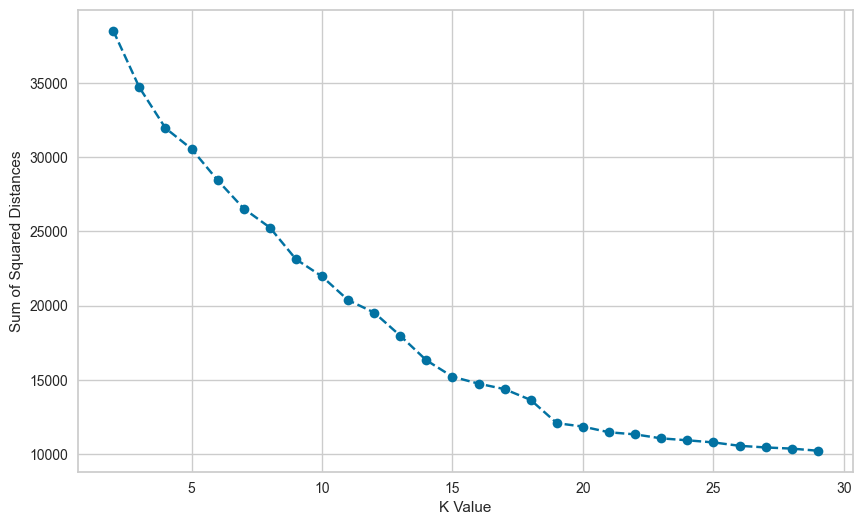

In [35]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(range(2, 30), ssd, 'o--')
plt.xlabel("K Value")
plt.ylabel("Sum of Squared Distances");

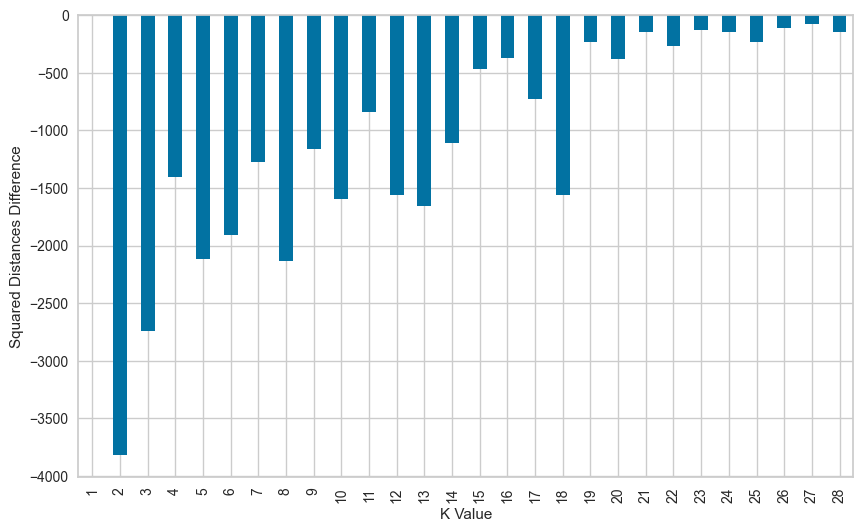

In [36]:
plt.figure(figsize=(10,6), dpi=100)
pd.Series(ssd).diff().plot(kind='bar')
plt.xticks(ticks=range(len(pd.Series(ssd).diff())), labels=range(1, len(pd.Series(ssd).diff()) + 1))
plt.xlabel("K Value")
plt.ylabel("Squared Distances Difference");

Можно предположить, что в точке K=4 падение метрики SSD более пологое - это может указывать на оптимальное количество кластеров, обеспечивающее баланс между сложностью модели и точностью кластеризации.

Обучим модель при n_clusters = 4:

In [37]:
model = KMeans(n_clusters=4, random_state=101)
model.fit(scaled_X)

KMeans(n_clusters=4, random_state=101)

In [38]:
model.labels_

array([2, 2, 2, ..., 3, 2, 1], dtype=int32)

Посмотрим, какие признаки являются наиболее важными при K=4:

In [39]:
X['K4_cluster_labels'] = model.labels_

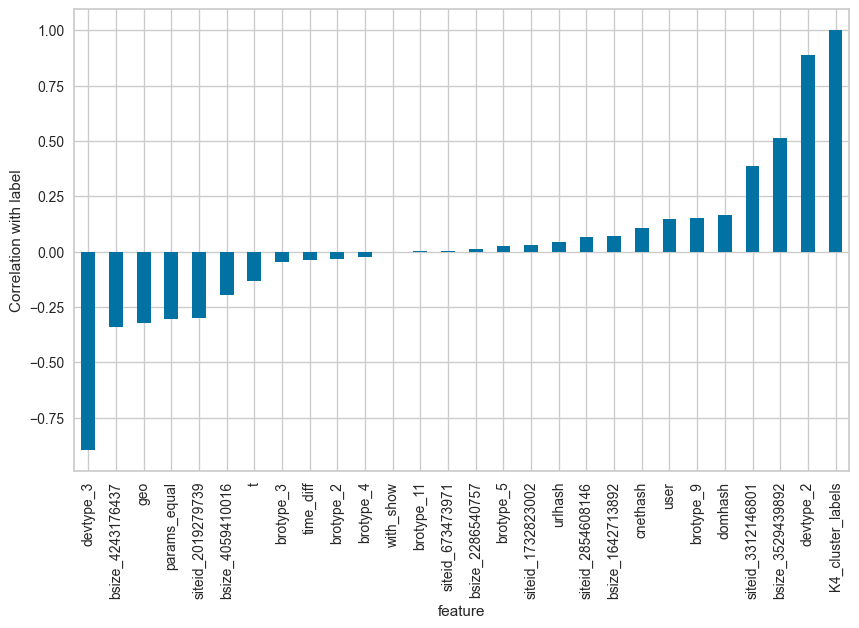

In [40]:
plt.figure(figsize=(10,6), dpi=100)
X.corr()['K4_cluster_labels'].sort_values().plot(kind='bar')
plt.xlabel("feature")
plt.ylabel("Correlation with label");

Также оценим качество кластеризации при К=4 с помощью метода силуэтов (silhouette method).

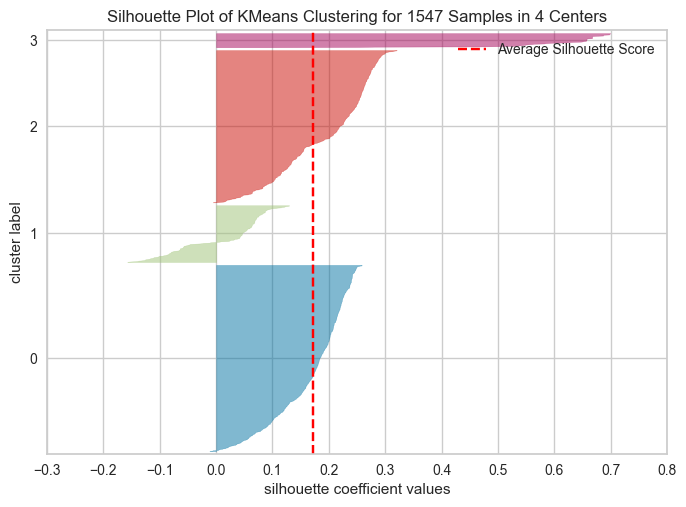

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1547 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=101))

In [41]:
silhouette_visualizer(model, scaled_X, colors='yellowbrick')

Видно, что значение коэффициента силуэта (около 0.2) довольно низкое, но при этом все кластеры, кроме одного (№1) пересекают его и не имеют отрицательных значений. Кластер №1 сильно выделяется на фоне остальных. Проверим - возможно, в него попали аномальные клики, обнаруженные при ручном анализе.

Добавим значения кластеров в датасет clicks, чтобы посмотреть, с каким из кластеров пересекается наибольшее число аномальных кликов, определенных вручную. Таким образом, проверим, может ли алгоритм kMeans выделить аномальные клики в отдельный кластер.

In [42]:
clicks['K4_cluster_labels'] = model.labels_

Сгруппируем данные по номерам кластеров и признаку manual_anomalous, затем посчитаем количество строк.

In [43]:
anomalous_counts = clicks.groupby(['K4_cluster_labels', 'manual_anomalous']).size().unstack(fill_value=0)

anomalous_counts

manual_anomalous,0,1
K4_cluster_labels,,
0,512,191
1,112,103
2,380,195
3,0,54


Видно, что аномальные клики из ручной выборки распределились по всем кластерам и наше предположение было неверным.

Далее посмотрим на точки внутри каждого кластера, расстояние от которых до центроида превышает некоторую пороговую величину (например, 95-й процентиль). Проверим, насколько эти точки можно считать аномальными кликами.

In [44]:
distances = model.transform(scaled_X)
X['distance_to_centroid'] = np.min(distances, axis=1)

threshold = np.percentile(X['distance_to_centroid'], 95)

X['kmeans_anomalous'] = X['distance_to_centroid'] > threshold

anomalous_clicks = X[X['kmeans_anomalous']]

In [45]:
clicks['kmeans_anomalous'] = X['kmeans_anomalous'].values.astype(int)

In [46]:
clicks

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous,with_show,params_equal,time_diff,K4_cluster_labels,kmeans_anomalous
0,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,0,1,1,63.0,2,0
1,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,15.0,2,0
2,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,11.0,2,0
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1,1,1,4.0,2,0
4,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,0,1,1,14.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,15879594241,373660,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,0,1,1,11.0,2,1
1543,16203440514,379349,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,0,1,1,6.0,2,1
1544,11601204597,276134,99334,1,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,1,1,0,6.0,3,0
1545,1987722430,40576,99649,1,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,0,1,1,20.0,2,0


Посмотрим на количество определенных таким образом аномальных кликов и на их пересечение с ручной выборкой.

In [47]:
len(clicks[clicks['kmeans_anomalous'] == 1])

78

In [48]:
len(clicks[(clicks['manual_anomalous'] == 1) & (clicks['kmeans_anomalous'] == 1)])

34

Видно, что второй вариант поиска выбросов (через расстояние до центроида) также оказался не очень эффективным - результаты практически не пересекаются с ручной выборкой.

Попробуем применить другой метод кластеризации - алгоритм DBSCAN.

### 4. Кластеризация DBSCAN

In [49]:
clicks

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous,with_show,params_equal,time_diff,K4_cluster_labels,kmeans_anomalous
0,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,0,1,1,63.0,2,0
1,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,15.0,2,0
2,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,11.0,2,0
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1,1,1,4.0,2,0
4,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,0,1,1,14.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,15879594241,373660,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,0,1,1,11.0,2,1
1543,16203440514,379349,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,0,1,1,6.0,2,1
1544,11601204597,276134,99334,1,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,1,1,0,6.0,3,0
1545,1987722430,40576,99649,1,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,0,1,1,20.0,2,0


In [50]:
X = clicks.drop(['eid','tn', 'manual_anomalous', 'K4_cluster_labels', 'kmeans_anomalous'], axis=1)
X

,t,user,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,with_show,params_equal,time_diff
0,72336,207,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,1,1,63.0
1,1135684,363,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,1,1,15.0
2,1135717,363,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,1,1,11.0
3,1208840,363,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1,1,4.0
4,376051,920,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,1,1,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,373660,99318,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,1,1,11.0
1543,379349,99318,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,1,1,6.0
1544,276134,99334,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,1,0,6.0
1545,40576,99649,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,1,1,20.0


Заменим отсутствующие значения в X на 0.

In [51]:
X = X.fillna(0)

Сделаем One-hot Encoding для признаков с небольшим значением уникальных значений. Для остальных признаков сделаем Label Encoding.

In [52]:
X = pd.get_dummies(X, columns=['devtype', 'brotype', 'bsize', 'siteid'], dtype=int, drop_first=True)

for feature in ['user', 'geo', 'cnethash', 'domhash', 'urlhash']:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])

Сделаем масштабирование признаков:

In [53]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

C помощью DBSCAN и цикла for создадим набор моделей для различных значений параметра эпсилон. В качестве параметра min_samples возьмем значение 2 умножить на количество признаков. Во время цикла будем сохранять процент точек-выбросов.

In [54]:
outlier_percent = []
number_of_outliers = []

for eps in np.linspace(0.001,10,100):
    
    dbscan = DBSCAN(eps=eps)
    dbscan.fit(scaled_X)

    number_of_outliers.append(np.sum(dbscan.labels_ == -1))

    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

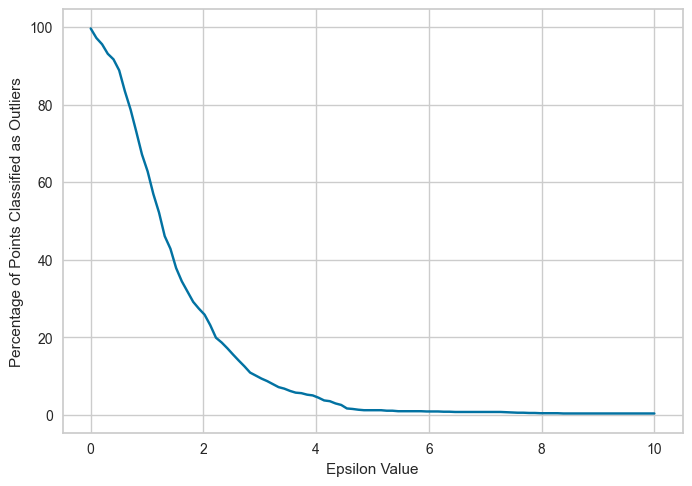

In [55]:
sns.lineplot(x=np.linspace(0.001,10,100),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value");

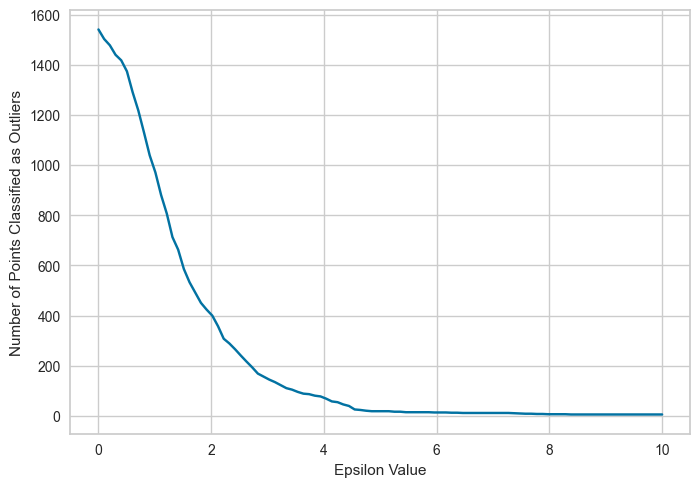

In [56]:
sns.lineplot(x=np.linspace(0.001,10,100),y=number_of_outliers)
plt.ylabel("Number of Points Classified as Outliers")
plt.xlabel("Epsilon Value");

Если ориентироваться на процент выбросов и расценивать его как процент аномальных кликов, можно предположить, что значение около 35 % будет соответствовать результатам, полученным вручную.

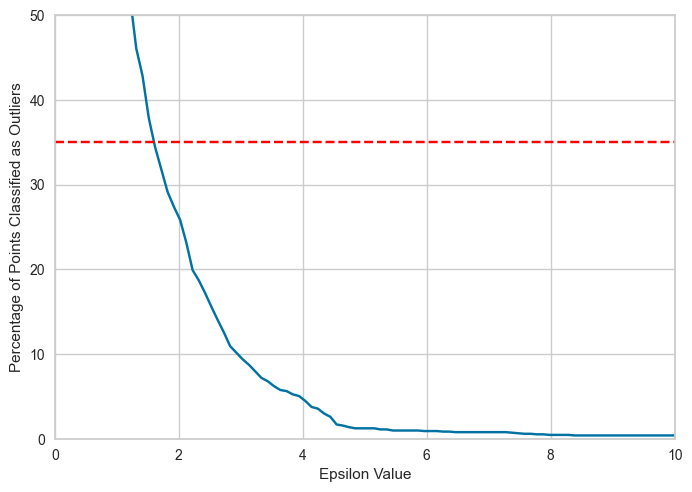

In [57]:
sns.lineplot(x=np.linspace(0.001,10,100),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")
plt.ylim(0,50)
plt.xlim(0,10)
plt.hlines(y=35,xmin=0,xmax=10,colors='red',ls='--');

Предположим, что оптимальное значение eps в нашем случае равно 1.5. Обучим модель с этим значением гиперпараметра.

In [58]:
dbscan = DBSCAN(eps=1.5)
dbscan.fit(scaled_X)

DBSCAN(eps=1.5)

In [59]:
clicks['DBSCAN_labels'] = dbscan.labels_
clicks['DBSCAN_anomalous'] = clicks['DBSCAN_labels'].apply(lambda x: 1 if x == -1 else 0)

In [60]:
clicks

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous,with_show,params_equal,time_diff,K4_cluster_labels,kmeans_anomalous,DBSCAN_labels,DBSCAN_anomalous
0,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,0,1,1,63.0,2,0,-1,1
1,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,15.0,2,0,2,0
2,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,0,1,1,11.0,2,0,2,0
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1,1,1,4.0,2,0,0,0
4,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,0,1,1,14.0,1,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,15879594241,373660,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,0,1,1,11.0,2,1,-1,1
1543,16203440514,379349,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,0,1,1,6.0,2,1,-1,1
1544,11601204597,276134,99334,1,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,1,1,0,6.0,3,0,-1,1
1545,1987722430,40576,99649,1,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,0,1,1,20.0,2,0,-1,1


Проверим количество аномальных кликов, обнаруженных с помощью DBSCAN, и проверим их пересечение с ручной выборкой.

In [61]:
len(clicks[clicks['DBSCAN_anomalous'] == 1])

594

In [62]:
clicks[(clicks['manual_anomalous'] == 1) & (clicks['DBSCAN_anomalous'] == 1)]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous,with_show,params_equal,time_diff,K4_cluster_labels,kmeans_anomalous,DBSCAN_labels,DBSCAN_anomalous
5,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,1,1,0,2.0,3,0,-1,1
6,356485962288,1219612,1435,1,390304810,1192490853539771097,3,2,3529439892,2019279739,8416208933617365004,9497642917282163363,1,1,1,4.0,0,0,-1,1
11,52000519449,1205756,1561,1,3369870328,7153086747091725409,3,2,4059410016,1732823002,6855870238177867981,16629187871008095825,1,1,0,9.0,0,0,-1,1
12,52002565624,1205800,1561,1,3369870328,7153086747091725409,3,2,390304810,1732823002,6855870238177867981,11452130590352027305,1,1,0,15.0,0,0,-1,1
26,46798586581,1079068,1971,1,127538460,1366742231653099824,3,2,3529439892,2019279739,7589661441840127586,14712548516689042055,1,1,1,2.0,0,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,33612898008,790449,98563,1,2169085419,13392210224384494515,2,2,390304810,1732823002,8226252734070597606,17200119249000175952,1,1,1,1.0,2,0,-1,1
1539,4075834339,101107,99144,1,2169085419,4239896307392508400,3,2,1642713892,673473971,5994715955150846703,5948040011910253044,1,1,0,8.0,1,0,-1,1
1540,32980152028,779879,99144,1,2169085419,3627804543293043122,3,2,4243176437,673473971,6857424429110098085,16105238177886081616,1,0,1,NaN,1,1,-1,1
1541,42055971128,973084,99209,1,239476928,9808897751740002020,2,2,2286540757,673473971,18369807234757086389,16595477858679529831,1,0,1,NaN,1,1,-1,1


Также проверим, в какой кластер попало наибольшее количество аномальных кликов, определенных вручную. Сгруппируем данные по номерам кластеров и признаку manual_anomalous, затем посчитаем количество строк.

In [63]:
anomalous_counts = clicks.groupby(['DBSCAN_labels', 'manual_anomalous']).size().unstack(fill_value=0)

anomalous_counts

manual_anomalous,0,1
DBSCAN_labels,,
-1,357,237
0,68,33
1,39,22
2,177,88
3,34,9
4,158,75
5,63,14
6,2,3
7,24,6


Видно, что практически половина аномальных кликов, согласно результатам ручного анализа, была также классифицирована как выбросы алгоритмом DBSCAN. Это интересный вывод, который подчеркивает применимость моделей кластеризации, особенно DBSCAN, в данной задаче. Однако стоит провести дополнительное тестирование различных комбинаций гиперпараметров для улучшения работы модели.

Важно отметить, что в данной задаче следует в первую очередь полагаться на результаты ручного анализа данных, так как алгоритмы кластеризации могут предоставлять сложно интерпретируемые результаты. Апробация KMeans и DBSCAN на тестовых данных это подтверждает.

## Итоги

В качестве результата проделанной работы, создадим датасет из аномальных (накрученных) кликов, выявленных вручную, и сохраним его в отдельный файл 'anomalous_clicks.tsv'.

In [64]:
anomalous_clicks = clicks[clicks['manual_anomalous'] == 1]

anomalous_clicks

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,manual_anomalous,with_show,params_equal,time_diff,K4_cluster_labels,kmeans_anomalous,DBSCAN_labels,DBSCAN_anomalous
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,1,1,1,4.0,2,0,0,0
5,24116705508,583769,1242,1,239476928,12973491721221869957,2,2,3529439892,3312146801,3148050604792748019,11848899605184181572,1,1,0,2.0,3,0,-1,1
6,356485962288,1219612,1435,1,390304810,1192490853539771097,3,2,3529439892,2019279739,8416208933617365004,9497642917282163363,1,1,1,4.0,0,0,-1,1
7,13938138174,336280,1492,1,239476928,17272734299351518174,2,2,3529439892,1732823002,16593058030122958800,10314716605508635827,1,1,1,3.0,2,0,1,0
11,52000519449,1205756,1561,1,3369870328,7153086747091725409,3,2,4059410016,1732823002,6855870238177867981,16629187871008095825,1,1,0,9.0,0,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,33612898008,790449,98563,1,2169085419,13392210224384494515,2,2,390304810,1732823002,8226252734070597606,17200119249000175952,1,1,1,1.0,2,0,-1,1
1539,4075834339,101107,99144,1,2169085419,4239896307392508400,3,2,1642713892,673473971,5994715955150846703,5948040011910253044,1,1,0,8.0,1,0,-1,1
1540,32980152028,779879,99144,1,2169085419,3627804543293043122,3,2,4243176437,673473971,6857424429110098085,16105238177886081616,1,0,1,NaN,1,1,-1,1
1541,42055971128,973084,99209,1,239476928,9808897751740002020,2,2,2286540757,673473971,18369807234757086389,16595477858679529831,1,0,1,NaN,1,1,-1,1


In [65]:
required_columns = [
    'eid', 't', 'user', 'tn', 'geo',
    'cnethash', 'devtype', 'brotype',
    'bsize', 'siteid', 'domhash', 'urlhash',
]

filtered_anomalous_clicks = anomalous_clicks[required_columns]

filtered_anomalous_clicks.to_csv('data/anomalous_clicks.tsv', sep='\t', index=False)

Таким образом, тестовые данные содержат 543 накрученных клика (35 % от общего числа кликов). Результат работы находится в папке data в файле 'anomalous_clicks.tsv'.